In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

In [3]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
train_data = pd.read_csv('./train.csv', index_col='PassengerId')
train_play = train_data.copy()
y = train_data.pop('Survived')
train = train_data.copy()

In [5]:
y.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

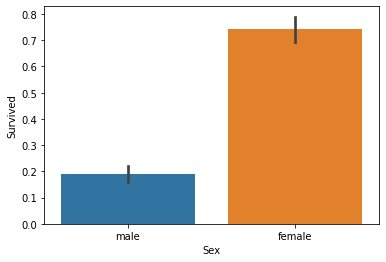

In [6]:
sns.barplot(x='Sex', y='Survived', data=train_play)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

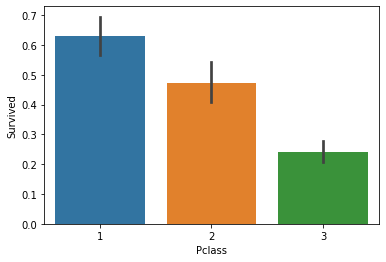

In [7]:
sns.barplot(x='Pclass', y='Survived', data=train_play)

In [8]:
test_data = pd.read_csv('./test.csv', index_col='PassengerId')

In [9]:
train_data.agg(['count', 'size', 'dtype'])

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,714,891,891,891,891,204,889
size,891,891,891,891,891,891,891,891,891,891
dtype,int64,object,object,float64,int64,int64,object,float64,object,object


In [10]:
col_names = 'Age', 'Fare', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Name', 'Cabin', 'Embarked', 'Ticket'
age_ix, fare_ix, pclass_ix, sex_ix, sibsp_ix, parch_ix, name_ix, cabin_ix, embarked_ix, ticket_ix = [train.columns.get_loc(c) for c in col_names]

In [11]:
class AttributesRounding(BaseEstimator, TransformerMixin):
    def __init__(self, col_ix=age_ix):
        self.col_ix = col_ix
        self.precision = 0
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = np.copy(X)
        X[:, [self.col_ix]] = np.round(X[:, [self.col_ix]].astype('float'), self.precision)
        return X

In [12]:
rounder = AttributesRounding()
train_data = rounder.transform(train_data.values)

<AxesSubplot:>

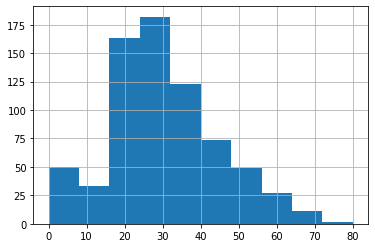

In [13]:
data = pd.DataFrame(train_data, columns=list(train.columns))
data['Age'].hist()

In [14]:
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,NaN,S


In [15]:
from sklearn.impute import KNNImputer, SimpleImputer 

In [16]:
class PriceCatGetter(BaseEstimator, TransformerMixin):
    def __init__(self, fare_ix=fare_ix, pclass_ix=pclass_ix, age_ix=age_ix):
        self.fare_ix = fare_ix
        self.pclass_ix = pclass_ix
        self.age_ix = age_ix
        self.limits = None
        self.knn_imputer = KNNImputer()
        self.imputer = SimpleImputer(strategy='most_frequent')
    
    def fit(self, X, y=None):
        self.imputer.fit(X[:, [self.pclass_ix]])
        self.knn_imputer.fit(X[:, [self.pclass_ix, self.fare_ix, self.age_ix]])
        
        price_data = pd.DataFrame(X[:, [self.fare_ix, self.pclass_ix]], columns=['Fare', 'Pclass'])
        cat_prices = []
        for pclass in [1, 2, 3]:
            cat_prices.append(
                pd.qcut(price_data.query(f'Pclass == {pclass}')['Fare'], 3, 
                        labels=[f'{name}_{pclass}' for name in ['low_price_class', 'medium_price_class', 'hihg_price_class']],
                        retbins=True, duplicates='drop'))
        self.limits = [cat_price[1] for cat_price in cat_prices]
        return self
    
    def transform(self, X):   
        X[:, [self.pclass_ix]] = self.imputer.transform(X[:, [self.pclass_ix]])
        X[:, [self.fare_ix]] = self.knn_imputer.transform(X[:, [self.pclass_ix, self.fare_ix, self.age_ix]])[:, [1]]
        
        return np.c_[X, np.vectorize(self.get_price_cat)(X[:, self.pclass_ix], X[:, self.fare_ix])]
    
    def get_price_cat(self, pclass, fare):
        pclass = int(pclass)
        if fare <= self.limits[pclass-1][1]:
            return f'low_price_class_{pclass}'
        elif fare <= self.limits[pclass-1][2]:
            return f'medium_price_class_{pclass}'
        elif fare > self.limits[pclass-1][2]:
            return f'high_price_class_{pclass}'
        else:
            print('error', pclass, fare, self-limits)      
            return f'medium_price_class_{pclass}'

In [17]:
pricer = PriceCatGetter()
train_data = pricer.fit_transform(train_data)
cat_price_ix = train_data.shape[1] - 1 

In [18]:
data = pd.DataFrame(train_data, columns=list(train.columns) + ['cat_price'])

<AxesSubplot:>

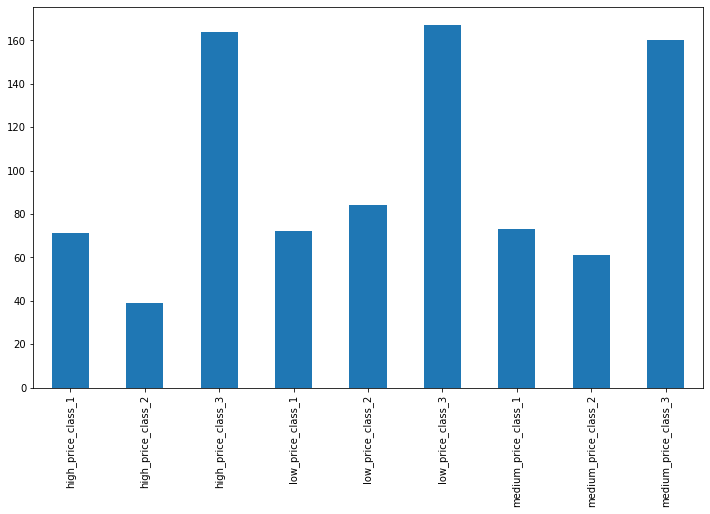

In [21]:
data['cat_price'].value_counts().sort_index().plot(kind='bar', figsize=(12,7))

In [23]:
class AgeImputor(BaseEstimator, TransformerMixin):
    def __init__(self, sex_ix=sex_ix, pclass_ix=pclass_ix, cat_price_ix=-1, age_ix=age_ix):
        self.sex_ix = sex_ix
        self.pclass_ix = pclass_ix
        self.cat_price_ix = cat_price_ix
        self.age_ix = age_ix
        self.ages = None
    
    def fit(self, X, y=None): 
        df = pd.DataFrame(X[:, [self.sex_ix, self.pclass_ix, self.cat_price_ix, self.age_ix]], 
                          columns=['Sex', 'Pclass', 'cat_price', 'Age']).convert_dtypes()
        median_age = df['Age'].median()
        self.ages = df.groupby(['Sex', 'Pclass', 'cat_price']).Age.agg('median').round(0).fillna(median_age).astype(int)
        return self
    
    def transform(self, X):
        df = pd.DataFrame(X[:, [self.sex_ix, self.pclass_ix, self.cat_price_ix, self.age_ix]], 
                  columns=['Sex', 'Pclass', 'cat_price', 'Age'])
        df.reset_index(inplace=True)
        df = df.merge(self.ages.reset_index().rename(columns={'Age': 'fill_age'}), left_on=['Sex', 'Pclass', 'cat_price'], 
                      right_on=['Sex', 'Pclass', 'cat_price'], sort=False, validate='many_to_one', how='left')
        df.sort_values('index', inplace=True)
        df['Age'].fillna(df['fill_age'], inplace=True)
        X[:, [self.age_ix]] = df[['Age']].values
        return X

In [24]:
ageimp = AgeImputor()
train_data = ageimp.fit_transform(train_data)

In [25]:
class AddFamily(BaseEstimator, TransformerMixin):
    def __init__(self, sibsp_ix=sibsp_ix, parch_ix=parch_ix, drop=False):
        self.sibsp_ix = sibsp_ix
        self.parch_ix = parch_ix
        self.drop = drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.drop:
            return X
    
        has_family = np.where((X[:, sibsp_ix] > 0) | (X[:, parch_ix] > 0), 'yes', 'no')
        return np.c_[X, has_family]

In [26]:
familyadder = AddFamily()
train_data = familyadder.fit_transform(train_data)
family_ix = train_data.shape[1] - 1 

In [27]:
data = pd.DataFrame(train_data, columns=list(train.columns) + ['cat_price', 'family'])

<AxesSubplot:>

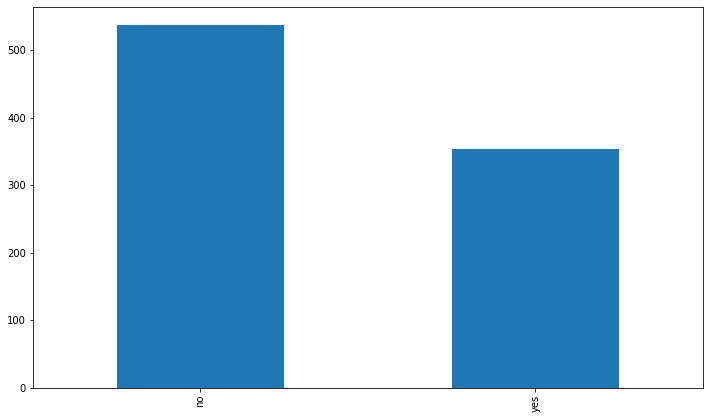

In [28]:
data['family'].value_counts().sort_index().plot(kind='bar', figsize=(12,7))

In [29]:
class AgeCat(BaseEstimator, TransformerMixin):
    def __init__(self, age_ix=age_ix, drop=False):
        self.age_ix = age_ix
        self.drop = drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.drop:
            return X
        age_cat = np.digitize(X[:, [self.age_ix]], bins=[0, 16, 45, 90])
        age_cat = np.vectorize({1:'child', 2:'adult', 3:'senior'}.get)(age_cat)
        return np.c_[X, age_cat]

In [30]:
ager = AgeCat()
train_data = ager.fit_transform(train_data)
age_cat_ix = train_data.shape[1] - 1 

In [31]:
data = pd.DataFrame(train_data, columns=list(train.columns) + ['cat_price', 'family', 'cat_age'])

<AxesSubplot:>

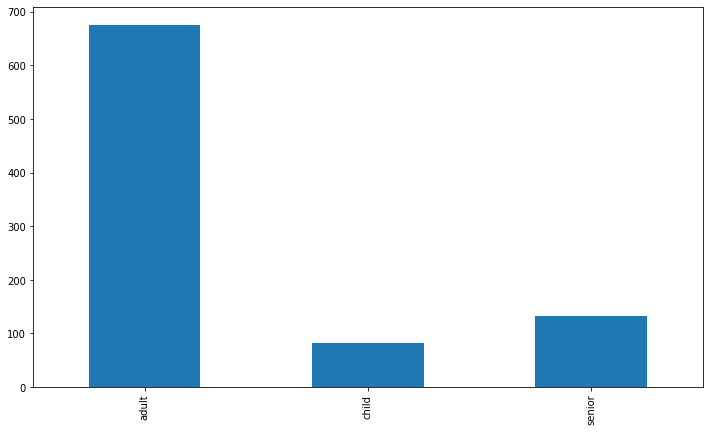

In [32]:
data['cat_age'].value_counts().sort_index().plot(kind='bar', figsize=(12,7))

<AxesSubplot:>

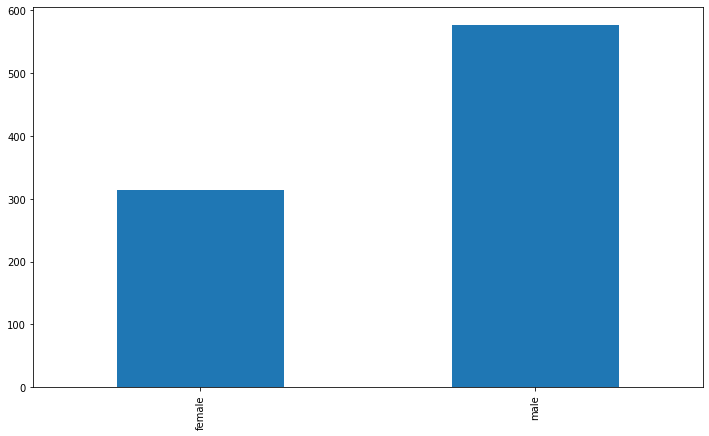

In [33]:
data['Sex'].value_counts().sort_index().plot(kind='bar', figsize=(12,7))

In [34]:
class NameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, name_ix=name_ix, sex_ix=sex_ix, age_ix=age_ix, drop=False):
        self.name_ix = name_ix
        self.age_ix = age_ix
        self.sex_ix = sex_ix
        self.drop = drop
        self.types_ = None
    
    def fit(self, X, y=None):
        
        if self.types_ is None or self.types_:
            self.types_ = []
            
        name_dict = [{'type': 'Mr.', 'pad': 'Mr.'},
             {'type': 'Mrs.', 'pad': 'Mrs.'},
             {'type': 'Miss', 'pad': 'Miss'},
             {'type': 'Master', 'pad': 'Master'},
             {'type': 'Army', 'pad': '(Major. |Col. |Capt. )'},
             {'type': 'Revered/Important', 'pad': '(Rev. |Countess. |Jonkheer. |Sir. |Lady. )'},
             {'type': 'rare', 'pad': '(Mme. |Ms. |Mlle. |Don. |Dona. )'},
             {'type': 'Doctor', 'pad': 'Dr.'}]
        
        df_name = pd.DataFrame(X[:, [self.name_ix]], columns=['Name'])
        for name in name_dict:
            if df_name['Name'].str.contains(pat=name['pad'], regex=True).sum() > 0:
                self.types_.append(name)
        return self
    
    def transform(self, X):
        if self.drop:
            return X
        X = np.copy(X)
        df_name = pd.DataFrame(X[:, [self.name_ix, self.age_ix, self.sex_ix]], columns=['Name', 'Age', 'Sex'])
        df = self.name_labeling(df_name)
        
        df.loc[(df['Name'] == "missing") & (df['Sex'] == 'female') & (df['Age'] < 17), 'Name'] = 'Mrs.'
        df.loc[(df['Name'] == "missing") & (df['Sex'] == 'female') & (df['Age'] >=17), 'Name'] = 'Miss'
        df.loc[(df['Name'] == "missing"), 'Name'] = 'Mr.'
        X[:, [self.name_ix]] = df[['Name']].values
        return X

    def name_labeling(self, df_in):
        df = df_in.copy()
        df['new_name'] = None
        for name in self.types_:
            if df['Name'].str.contains(pat=name['pad'], regex=True).sum() > 0:
                tmp_idx = df.loc[df['Name'].str.contains(pat=name['pad'], regex=True), 'Name'].index
                df.loc[tmp_idx, 'new_name'] = name['type']
        df['new_name'].fillna('missing', inplace=True)
        df['Name'] = df['new_name']
        df.drop(columns=['new_name'], inplace=True)
        return df

In [35]:
nametrans = NameTransformer()
train_data = nametrans.fit_transform(train_data)

<AxesSubplot:>

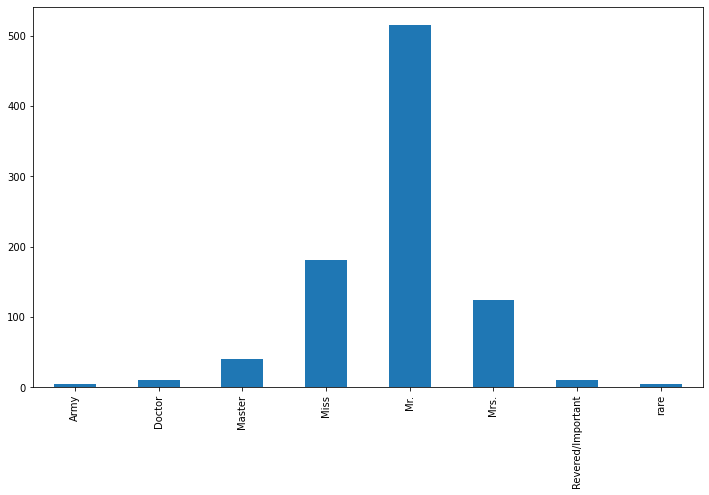

In [36]:
data = pd.DataFrame(train_data, columns=list(train.columns) + ['cat_price', 'family', 'cat_age'])
data['Name'].value_counts().sort_index().plot(kind='bar', figsize=(12,7))

In [37]:
data.convert_dtypes().groupby('Name')['Age'].mean()

Name
Army                 56.600000
Doctor               38.272727
Master                5.925000
Miss                 21.613260
Mr.                  31.376699
Mrs.                 34.645161
Revered/Important    42.700000
rare                 28.000000
Name: Age, dtype: float64

In [38]:
data.convert_dtypes().groupby('Name')['Age'].min()

Name
Army                 45
Doctor               21
Master                0
Miss                  1
Mr.                  11
Mrs.                 14
Revered/Important    27
rare                 24
Name: Age, dtype: Int64

In [39]:
data.convert_dtypes().groupby('Name')['Age'].max()

Name
Army                 70
Doctor               54
Master               18
Miss                 63
Mr.                  80
Mrs.                 63
Revered/Important    57
rare                 40
Name: Age, dtype: Int64

In [40]:
class CabinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cabin_ix=cabin_ix, pclass_ix=pclass_ix, drop=False):
        self.cabin_ix = cabin_ix
        self.pclass_ix = pclass_ix
        self.probs_cabin = None
        self.drop = drop
    
    def fit(self, X, y=None):
        if self.drop:
            return self
        data = pd.DataFrame(X[:, [self.pclass_ix, self.cabin_ix]], columns=['Pclass', 'Cabin'])
        data = self.cabin_labeling(data)
        counts = data.groupby(['Pclass', 'Cabin'])['Pclass'].count().unstack().drop(columns=['missing'], errors='ignore')
        self.probs_cabin = counts.div(counts.sum(axis=1), axis=0).fillna(0)
        return self
    
    def transform(self, X):
        if self.drop:
            return X
        X = np.copy(X)
        df_cabin = pd.DataFrame(X[:, [self.cabin_ix, self.pclass_ix]], columns=['Cabin', 'Pclass'])
        df = self.cabin_labeling(df_cabin)
        df['Cabin'] = df.apply(lambda row: self.get_rnd_cabin_label(row['Cabin'], row['Pclass']), axis=1)
        X[:, [self.cabin_ix]] = df[['Cabin']].values
        return X

    @staticmethod
    def cabin_labeling(df_in):
        df = df_in.copy()
        df['new_cabin'] = None
        for cabin_label in df['Cabin'].dropna().str[0].unique():
            tmp_index = df.loc[df['Cabin'].str.contains(cabin_label, na=False), 'Cabin'].index
            df.loc[tmp_index, 'new_cabin'] = cabin_label
        df['new_cabin'].fillna('missing', inplace=True)
        df['Cabin'] = df['new_cabin']
        df.drop(columns=['new_cabin'], inplace=True)
        return df
    
    def get_rnd_cabin_label(self, cabin_label, pclass):
        return np.random.choice(self.probs_cabin.loc[pclass].index, size=1, 
                                p=self.probs_cabin.loc[pclass].values)[0] if cabin_label not in self.probs_cabin.columns else cabin_label

In [41]:
cabintrans = CabinTransformer()
train_data = cabintrans.fit_transform(train_data)

<AxesSubplot:>

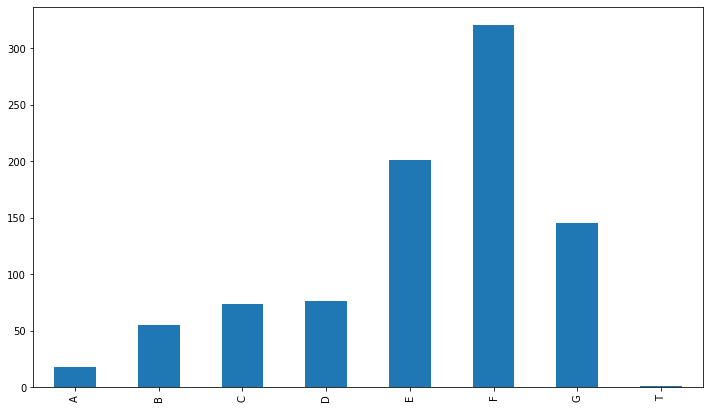

In [42]:
data = pd.DataFrame(train_data, columns=list(train.columns) + ['cat_price', 'family', 'cat_age'])
data['Cabin'].value_counts().sort_index().plot(kind='bar', figsize=(12,7))

In [43]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# pipeline

In [44]:
initial_pipeline = Pipeline([
    ('price_cat', PriceCatGetter()),
    ('age_imputor', AgeImputor()),
    ('add_family', AddFamily()),
    ('age_cat', AgeCat()),
    ('imputor', SimpleImputer(strategy='most_frequent')),
    ('rounding', AttributesRounding()),
    ('name', NameTransformer()),
    ('cabin', CabinTransformer())
])

In [45]:
initial_pipeline.fit_transform(train.values, y)

array([[3, 'Mr.', 'male', ..., 'low_price_class_3', 'yes', 'adult'],
       [1, 'Mrs.', 'female', ..., 'medium_price_class_1', 'yes', 'adult'],
       [3, 'Miss', 'female', ..., 'medium_price_class_3', 'no', 'adult'],
       ...,
       [3, 'Miss', 'female', ..., 'high_price_class_3', 'yes', 'adult'],
       [1, 'Mr.', 'male', ..., 'low_price_class_1', 'no', 'adult'],
       [3, 'Mr.', 'male', ..., 'low_price_class_3', 'no', 'adult']],
      dtype=object)

In [46]:
num_features = [fare_ix, age_ix]
cat_features = [family_ix, sex_ix, pclass_ix, cabin_ix, embarked_ix, name_ix]

col_transformer = ColumnTransformer(
                    transformers=[
                        ('num', SimpleImputer(strategy='median'), num_features),
                        ('cat', OneHotEncoder(drop='first', handle_unknown='error'), cat_features)
                    ],
                    remainder='drop',
                    n_jobs=1
                    )

# data analysis

In [47]:
play_data = pd.concat([pd.DataFrame(initial_pipeline.fit_transform(train.values), 
                                    columns=['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 
                                             'Ticket', 'Fare', 'Cabin', 'Embarked', 'cat_price', 
                                             'family', 'cat_age'], 
                                    index=range(1, train.values.shape[0]+1)), y], axis=1)

In [48]:
play_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cat_price,family,cat_age,Survived
1,3,Mr.,male,22,1,0,A/5 21171,7.25,B,S,low_price_class_3,yes,adult,0
2,1,Mrs.,female,38,1,0,PC 17599,71.2833,C,C,medium_price_class_1,yes,adult,1
3,3,Miss,female,26,0,0,STON/O2. 3101282,7.925,B,S,medium_price_class_3,no,adult,1
4,1,Mrs.,female,35,1,0,113803,53.1,C,S,medium_price_class_1,yes,adult,1
5,3,Mr.,male,35,0,0,373450,8.05,B,S,medium_price_class_3,no,adult,0


In [49]:
train_play.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:xlabel='Sex', ylabel='Survived'>

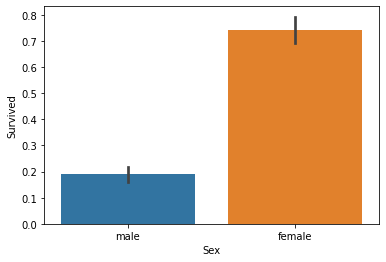

In [50]:
sns.barplot(x='Sex', y='Survived', data=play_data)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

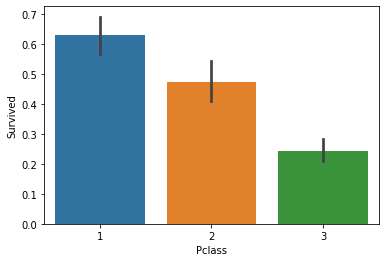

In [51]:
sns.barplot(x='Pclass', y='Survived', data=play_data)

In [61]:
def list_results(search_cv):
    results = []
    for params, score in zip(search_cv.cv_results_['params'], search_cv.cv_results_['mean_test_score']):
        params['score'] = score
        results.append(params)
    return pd.DataFrame(results).sort_values(by='score', ascending=False)
        
def save_results(test_data, pred, num):
    result = pd.DataFrame((pred > 0.5)[:, np.newaxis].astype(int), index=test_data.index, columns=['Survived'])
    result.to_csv(f'submit_{num}.csv')
    
def get_learning_curve(model, X, y, start, step):
    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(start, len(X_train), step):
        print(m/len(X_train))
        model.fit(X_train[:m], y_train[:m])
        train_pred = model.predict(X_train[:m])
        val_pred = model.predict(X_val)
        train_errors.append(accuracy_score(y_train[:m], train_pred))
        val_errors.append(accuracy_score(y_val, val_pred))
    return train_errors, val_errors 

def plot_learning_curve(model):
    start = 100
    step = 20
    t, v = get_learning_curve(model, train.values, y, start, step)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
    ax.plot(np.arange(start, start+step*len(t), step), np.sqrt(t), 'r-', marker='x', label='train')
    ax.plot(np.arange(start, start+step*len(v), step), np.sqrt(v), 'b-', marker='o', label='val')
    ax.grid(True)
    ax.set(xlabel='iteration', ylabel='accuracy')
    plt.legend()

In [52]:
def get_feature_importance(train, y):
    pipeline = Pipeline([
        ('initial', initial_pipeline),
        ('onehot', col_transformer),
        ('model', RandomForestClassifier())
    ])
    pipeline.fit(train.values, y)
    cols = pipeline.named_steps['onehot'].transformers_[0][2] + pipeline.named_steps['onehot'].transformers_[1][1].get_feature_names().tolist()
    feature_importances = pipeline.named_steps['model'].feature_importances_
    importances = pd.DataFrame(feature_importances, index=cols, columns=['importance'])
    return importances, feature_importances

In [53]:
features, saved_feature_importances = get_feature_importance(train, y)

In [54]:
features.sort_values(by='importance', ascending=False)

,importance
7,0.250714
3,0.235180
x1_male,0.126591
x5_Mr.,0.108658
x2_3,0.058269
x5_Miss,0.037464
x5_Mrs.,0.035889
x3_B,0.025266
x0_yes,0.022327
x4_S,0.022029


# RDF

In [55]:
full_pipeline_rdf = Pipeline([
    ('initial', initial_pipeline),
    ('onehot', col_transformer),
    ('model', RandomForestClassifier())
])

In [56]:
print(full_pipeline_rdf.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'initial', 'onehot', 'model', 'initial__memory', 'initial__steps', 'initial__verbose', 'initial__price_cat', 'initial__age_imputor', 'initial__add_family', 'initial__age_cat', 'initial__imputor', 'initial__rounding', 'initial__name', 'initial__cabin', 'initial__price_cat__age_ix', 'initial__price_cat__fare_ix', 'initial__price_cat__pclass_ix', 'initial__age_imputor__age_ix', 'initial__age_imputor__cat_price_ix', 'initial__age_imputor__pclass_ix', 'initial__age_imputor__sex_ix', 'initial__add_family__drop', 'initial__add_family__parch_ix', 'initial__add_family__sibsp_ix', 'initial__age_cat__age_ix', 'initial__age_cat__drop', 'initial__imputor__add_indicator', 'initial__imputor__copy', 'initial__imputor__fill_value', 'initial__imputor__missing_values', 'initial__imputor__strategy', 'initial__imputor__verbose', 'initial__rounding__col_ix', 'initial__name__age_ix', 'initial__name__drop', 'initial__name__name_ix', 'initial__name__sex_ix', 'initial__c

In [57]:
full_pipeline_rdf.get_params()['onehot__transformers']

[('num', SimpleImputer(strategy='median'), [7, 3]),
 ('cat', OneHotEncoder(drop='first'), [11, 2, 0, 8, 9, 1])]

In [58]:
full_pipeline_rdf.fit(train.values, y)

Pipeline(steps=[('initial',
                 Pipeline(steps=[('price_cat', PriceCatGetter()),
                                 ('age_imputor', AgeImputor()),
                                 ('add_family', AddFamily()),
                                 ('age_cat', AgeCat()),
                                 ('imputor',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('rounding', AttributesRounding()),
                                 ('name', NameTransformer()),
                                 ('cabin', CabinTransformer())])),
                ('onehot',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  [7, 3]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'

In [59]:
param_grid_rdf = [
    {'onehot__transformers': [[('num', SimpleImputer(strategy='median'), [fare_ix, age_ix, parch_ix, sibsp_ix]),
                               ('cat', OneHotEncoder(drop='first'), [name_ix, cabin_ix, pclass_ix, age_cat_ix, family_ix, embarked_ix, sex_ix, cat_price_ix])],
                              [('num', SimpleImputer(strategy='median'), [fare_ix]),
                               ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix])],
                              [('num', SimpleImputer(strategy='median'), [fare_ix]),
                               ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix, name_ix, cabin_ix])],
                              [('num', SimpleImputer(strategy='median'), [fare_ix]),
                               ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix, name_ix, cabin_ix, embarked_ix])]   
                             ],
     'model__n_estimators': [150, 180, 200, 225],
     #'model__criterion': ['gini', 'entropy'],
     #'model__max_features': ['auto', 'log2', None],
     #'model__bootstrap': [False, True],
     'model__min_samples_leaf': [8, 10, 12, 15, 17, 20],
     'model__min_samples_split': [8, 10, 12, 15, 20],
     
     #{'n_estimators':[300, 500, 1000],
     #                'max_depth':[5, 9],
     #                'max_samples':[0.5, 0.7, 0.9],
     #                'max_features':[0.5, 0.7, 0.9], 
     #                'min_samples_split':[2, 5, 8]
    }
]

search_rdf = RandomizedSearchCV(full_pipeline_rdf, param_grid_rdf, n_iter=10, 
                            cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42), 
                            refit=True, verbose=2, n_jobs=1, scoring='accuracy')

In [60]:
search_rdf.fit(train.values, y)

Fitting 20 folds for each of 10 candidates, totalling 200 fits
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=225, model__min_samples_split=8, model__min_samples_leaf=17 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=225, model__min_samples_split=8, model__min_samples_leaf=17, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=225, model__min_samples_split=8, model__min_samples_leaf=17 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=225, model__min_samples_split=8, model__min_samples_leaf=17, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=225, model__min_samples_split=8, model__min_samples_leaf=17 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=225, model__min_samples_split=8, model__min_samples_leaf=17, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=225, model__min_samples_split=8, model__min_samples_leaf=17 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHot

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=225, model__min_samples_split=15, model__min_samples_leaf=17, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=225, model__min_samples_split=15, model__min_samples_leaf=17 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=225, model__min_samples_split=15, model__min_samples_leaf=17, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=225, model__min_samples_split=15, model__min_samples_leaf=17 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 1

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=225, model__min_samples_split=15, model__min_samples_leaf=17, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=200, model__min_samples_split=12, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=200, model__min_samples_split=12, model__min_samples_leaf=15, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=200, model__min_samples_split=12, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num', SimpleImputer(strate

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=200, model__min_samples_split=12, model__min_samples_leaf=15, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=200, model__min_samples_split=12, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=200, model__min_samples_split=12, model__min_samples_leaf=15, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=200, model__min_samples_split=12, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num'

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__n_estimators=225, model__min_samples_split=15, model__min_samples_leaf=10, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__n_estimators=225, model__min_samples_split=15, model__min_samples_leaf=10 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__n_estimators=225, model__min_samples_split=15, model__min_samples_leaf=10, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__n_estimators=225, model__min_samples_split=15, model__min_samples_leaf=10 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=225, model__min_samples_split=12, model__min_samples_leaf=17, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=225, model__min_samples_split=12, model__min_samples_leaf=17 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=225, model__min_samples_split=12, model__min_samples_leaf=17, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=225, model__min_samples_split=12, model__min_samples_leaf=17 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 1

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=200, model__min_samples_split=20, model__min_samples_leaf=10, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=200, model__min_samples_split=20, model__min_samples_leaf=10 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=200, model__min_samples_split=20, model__min_samples_leaf=10, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=200, model__min_samples_split=20, model__min_samples_leaf=10 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 1

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=150, model__min_samples_split=12, model__min_samples_leaf=15, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=150, model__min_samples_split=12, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=150, model__min_samples_split=12, model__min_samples_leaf=15, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__n_estimators=150, model__min_samples_split=12, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', On

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=150, model__min_samples_split=15, model__min_samples_leaf=17, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=150, model__min_samples_split=15, model__min_samples_leaf=17 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=150, model__min_samples_split=15, model__min_samples_leaf=17, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=150, model__min_samples_split=15, model__min_samples_leaf=17 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 1

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=180, model__min_samples_split=12, model__min_samples_leaf=15, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=180, model__min_samples_split=12, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=180, model__min_samples_split=12, model__min_samples_leaf=15, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__n_estimators=180, model__min_samples_split=12, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 1

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=225, model__min_samples_split=20, model__min_samples_leaf=15, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=225, model__min_samples_split=20, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=225, model__min_samples_split=20, model__min_samples_leaf=15, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__n_estimators=225, model__min_samples_split=20, model__min_samples_leaf=15 
[CV]  onehot__transformers=[('num'

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.4min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=42),
                   estimator=Pipeline(steps=[('initial',
                                              Pipeline(steps=[('price_cat',
                                                               PriceCatGetter()),
                                                              ('age_imputor',
                                                               AgeImputor()),
                                                              ('add_family',
                                                               AddFamily()),
                                                              ('age_cat',
                                                               AgeCat()),
                                                              ('imputor',
                                                               SimpleImputer(strategy='most_frequent')),
                                                          

In [62]:
list_results(search_rdf)

,onehot__transformers,model__n_estimators,model__min_samples_split,model__min_samples_leaf,score
2,"[(num, SimpleImputer(strategy='median'), [7, 3...",200,12,15,0.821536
9,"[(num, SimpleImputer(strategy='median'), [7, 3...",225,20,15,0.820974
5,"[(num, SimpleImputer(strategy='median'), [7]),...",200,20,10,0.809757
6,"[(num, SimpleImputer(strategy='median'), [7]),...",150,12,15,0.808620
3,"[(num, SimpleImputer(strategy='median'), [7]),...",225,15,10,0.807497
0,"[(num, SimpleImputer(strategy='median'), [7]),...",225,8,17,0.803577
8,"[(num, SimpleImputer(strategy='median'), [7]),...",180,12,15,0.802453
7,"[(num, SimpleImputer(strategy='median'), [7]),...",150,15,17,0.798539
4,"[(num, SimpleImputer(strategy='median'), [7]),...",225,12,17,0.796866
1,"[(num, SimpleImputer(strategy='median'), [7]),...",225,15,17,0.795762


In [63]:
pred = search_rdf.best_estimator_.predict(test_data.values)

In [64]:
save_results(test_data, pred, 'rdf_1')

0.1404494382022472
0.16853932584269662
0.19662921348314608
0.2247191011235955
0.25280898876404495
0.2808988764044944
0.3089887640449438
0.33707865168539325
0.3651685393258427
0.39325842696629215
0.42134831460674155
0.449438202247191
0.47752808988764045
0.5056179775280899
0.5337078651685393
0.5617977528089888
0.5898876404494382
0.6179775280898876
0.6460674157303371
0.6741573033707865
0.702247191011236
0.7303370786516854
0.7584269662921348
0.7865168539325843
0.8146067415730337
0.8426966292134831
0.8707865168539326
0.898876404494382
0.9269662921348315
0.9550561797752809
0.9831460674157303


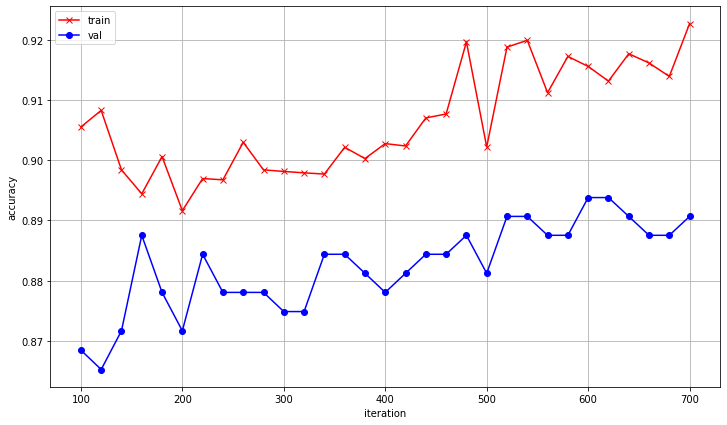

In [66]:
plot_learning_curve(search_rdf.best_estimator_)

# SVC

In [67]:
from sklearn.svm import SVC

In [68]:
full_pipeline_svc = Pipeline([
    ('initial', initial_pipeline),
    ('onehot', col_transformer),
    ('model', SVC())
])

In [69]:
param_grid_svc = [
#    {
#    'onehot__transformers': [[('num', SimpleImputer(strategy='median'), [fare_ix, age_ix, parch_ix, sibsp_ix]),
#                           ('cat', OneHotEncoder(drop='first'), [name_ix, cabin_ix, pclass_ix, age_cat_ix, family_ix, embarked_ix, sex_ix, cat_price_ix])],
#                          [('num', SimpleImputer(strategy='median'), [fare_ix]),
#                           ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix])],
#                          [('num', SimpleImputer(strategy='median'), [fare_ix]),
#                           ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix, name_ix, cabin_ix])],
#                          [('num', SimpleImputer(strategy='median'), [fare_ix]),
#                           ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix, name_ix, cabin_ix, embarked_ix])]   
#                         ],
#     'model__kernel': ['poly'],
#     'model__degree': [2, 3, 4],
#     'model__coef0': [0.5, 1, 10, 100],
#     'model__C': [0.01, 0.1, 1, 10, 100, 1000]
#    },
    {
    'onehot__transformers': [[('num', SimpleImputer(strategy='median'), [fare_ix, age_ix, parch_ix, sibsp_ix]),
                   ('cat', OneHotEncoder(drop='first'), [name_ix, cabin_ix, pclass_ix, age_cat_ix, family_ix, embarked_ix, sex_ix, cat_price_ix])],
                  [('num', SimpleImputer(strategy='median'), [fare_ix]),
                   ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix])],
                  [('num', SimpleImputer(strategy='median'), [fare_ix]),
                   ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix, name_ix, cabin_ix])],
                  [('num', SimpleImputer(strategy='median'), [fare_ix]),
                   ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix, name_ix, cabin_ix, embarked_ix])]   
                 ],
     'model__kernel': ['rbf'],
     'model__gamma': 0.01 * np.arange(100),
     'model__C': [0.01, 0.1, 1, 5],
     'model__probability':[True]}
]

In [70]:
search_svc = RandomizedSearchCV(full_pipeline_svc, param_grid_svc, n_iter=10, 
                            cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42), 
                            refit=True, verbose=2, n_jobs=1, scoring='accuracy')

In [71]:
search_svc.fit(train.values, y)

Fitting 20 folds for each of 10 candidates, totalling 200 fits
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.51, model__C=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.51, model__C=1, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.51, model__C=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.51, model__C=1, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.51, model__C=1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.51, model__C=1, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.51, model__C=1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.8200000000000001, model__C=0.01, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.8200000000000001, model__C=0.01 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.8200000000000001, model__C=0.01, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.8200000000000001, model__C=0.01 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat'

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.8200000000000001, model__C=0.01, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.8200000000000001, model__C=0.01 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.8200000000000001, model__C=0.01, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.22, model__C=0.1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneH

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.22, model__C=0.1, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.22, model__C=0.1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.22, model__C=0.1, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.22, model__C=0.1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='fi

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.81, model__C=1, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.81, model__C=1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.81, model__C=1, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.81, model__C=1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.58, model__C=1, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.58, model__C=1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.58, model__C=1, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.58, model__C=1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.26, model__C=0.1, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.26, model__C=0.1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.26, model__C=0.1, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.26, model__C=0.1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__prob

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.34, model__C=0.01, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.34, model__C=0.01 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.34, model__C=0.01, total=   0.2s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.34, model__C=0.01 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.81, model__C=5, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.81, model__C=5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.81, model__C=5, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__probability=True, model__kernel=rbf, model__gamma=0.81, model__C=5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.65, model__C=0.01, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.65, model__C=0.01 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.65, model__C=0.01, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__probability=True, model__kernel=rbf, model__gamma=0.65, model__C=0.01 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.34, model__C=1, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.34, model__C=1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.34, model__C=1, total=   0.3s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=True, model__kernel=rbf, model__gamma=0.34, model__C=1 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__probability=

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   54.3s finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=42),
                   estimator=Pipeline(steps=[('initial',
                                              Pipeline(steps=[('price_cat',
                                                               PriceCatGetter()),
                                                              ('age_imputor',
                                                               AgeImputor()),
                                                              ('add_family',
                                                               AddFamily()),
                                                              ('age_cat',
                                                               AgeCat()),
                                                              ('imputor',
                                                               SimpleImputer(strategy='most_frequent')),
                                                          

In [72]:
list_results(search_svc)

,onehot__transformers,model__probability,model__kernel,model__gamma,model__C,score
3,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.81,1.00,0.811454
0,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.51,1.00,0.801935
7,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.81,5.00,0.799132
4,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.58,1.00,0.796336
9,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.34,1.00,0.792940
2,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.22,0.10,0.670599
5,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.26,0.10,0.640287
1,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.82,0.01,0.616167
6,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.34,0.01,0.616167
8,"[(num, SimpleImputer(strategy='median'), [7]),...",True,rbf,0.65,0.01,0.616167


0.1404494382022472
0.16853932584269662
0.19662921348314608
0.2247191011235955
0.25280898876404495
0.2808988764044944
0.3089887640449438
0.33707865168539325
0.3651685393258427
0.39325842696629215
0.42134831460674155
0.449438202247191
0.47752808988764045
0.5056179775280899
0.5337078651685393
0.5617977528089888
0.5898876404494382
0.6179775280898876
0.6460674157303371
0.6741573033707865
0.702247191011236
0.7303370786516854
0.7584269662921348
0.7865168539325843
0.8146067415730337
0.8426966292134831
0.8707865168539326
0.898876404494382
0.9269662921348315
0.9550561797752809
0.9831460674157303


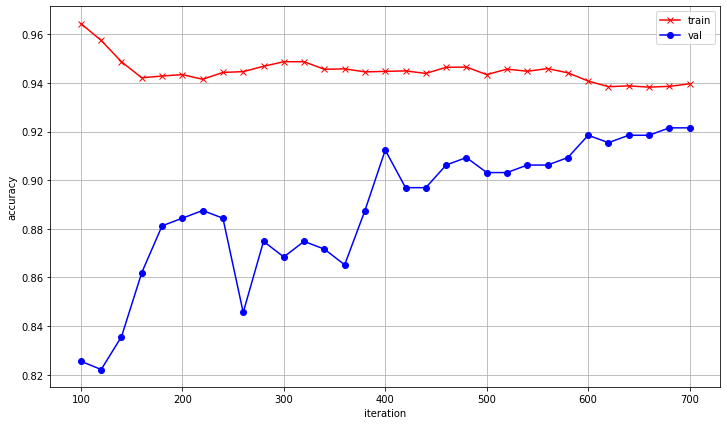

In [73]:
plot_learning_curve(search_svc.best_estimator_)

In [74]:
pred_svc = search_svc.best_estimator_.predict(test_data.values)

In [75]:
save_results(test_data, pred_svc, 'svc_2')

# XGB

In [76]:
from xgboost import XGBClassifier

In [77]:
full_pipeline_xgb = Pipeline([
    ('initial', initial_pipeline),
    ('onehot', col_transformer),
    ('model', XGBClassifier())
])

In [78]:
param_grid_xgb = {
                'onehot__transformers': [[('num', SimpleImputer(strategy='median'), [fare_ix, age_ix, parch_ix, sibsp_ix]),
                           ('cat', OneHotEncoder(drop='first'), [name_ix, cabin_ix, pclass_ix, age_cat_ix, family_ix, embarked_ix, sex_ix, cat_price_ix])],
                          [('num', SimpleImputer(strategy='median'), [fare_ix]),
                           ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix])],
                          [('num', SimpleImputer(strategy='median'), [fare_ix]),
                           ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix, name_ix, cabin_ix])],
                          [('num', SimpleImputer(strategy='median'), [fare_ix]),
                           ('cat', OneHotEncoder(drop='first'), [family_ix, pclass_ix, age_cat_ix, sex_ix, name_ix, cabin_ix, embarked_ix])]   
                         ],
                  'model__n_estimators':[400, 600],
                  'model__learning_rate':[0.01, 0.03, 0.05],
                  'model__max_depth':[3, 4],
                  'model__subsample':[0.5, 0.7],
                  'model__colsample_bylevel':[0.5, 0.7],
                  'model__reg_lambda':[15, None],
                 }

In [79]:
search_xgb = RandomizedSearchCV(full_pipeline_xgb, param_grid_xgb, n_iter=10, 
                            cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42), 
                            refit=True, verbose=2, n_jobs=1, scoring='accuracy')

In [80]:
search_xgb.fit(train.values, y)

Fitting 20 folds for each of 10 candidates, totalling 200 fits
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.5, total=   0.5s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.7, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.7 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.7, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.05, model__colsample_bylevel=0.5, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.05, model__colsample_bylevel=0.5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.05, model__colsample_bylevel=0.5, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.05, model__colsample_bylevel=0.5, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.05, model__colsample_bylevel=0.5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.05, model__colsample_bylevel=0.5, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.7, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.7 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.01, model__colsample_bylevel=0.7, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=400, model__max_depth=4, model__learning_rate=0.01, model__colsample_bylevel=0.7, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=400, model__max_depth=4, model__learning_rate=0.01, model__colsample_bylevel=0.7 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=400, model__max_depth=4, model__learning_rate=0.01, model__colsample_bylevel=0.7, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7, 3, 5, 4]), ('cat', OneHotEncoder(drop='first'), [1, 8, 0, 12, 11, 9, 2, 10])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=400, model__max_depth=4, model__learning_rate=0.01, model__colsample_bylevel=0.7, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=400, model__max_depth=4, model__learning_rate=0.03, model__colsample_bylevel=0.5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=400, model__max_depth=4, model__learning_rate=0.03, model__colsample_bylevel=0.5, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [1

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=400, model__max_depth=4, model__learning_rate=0.03, model__colsample_bylevel=0.5, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=400, model__max_depth=4, model__learning_rate=0.03, model__colsample_bylevel=0.5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__subsample=0.7, model__reg_lambda=None, model__n_estimators=400, model__max_depth=4, model__learning_rate=0.03, model__colsample_bylevel=0.5, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model_

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__subsample=0.5, model__reg_lambda=None, model__n_estimators=600, model__max_depth=4, model__learning_rate=0.01, model__colsample_bylevel=0.7, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__subsample=0.5, model__reg_lambda=None, model__n_estimators=600, model__max_depth=4, model__learning_rate=0.01, model__colsample_bylevel=0.7 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model__subsample=0.5, model__reg_lambda=None, model__n_estimators=600, model__max_depth=4, model__learning_rate=0.01, model__colsample_bylevel=0.7, total=   0.1s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2])], model_

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=4, model__learning_rate=0.05, model__colsample_bylevel=0.7, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=4, model__learning_rate=0.05, model__colsample_bylevel=0.7 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=4, model__learning_rate=0.05, model__colsample_bylevel=0.7, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8, 9])], model__subsample=0.5, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11

[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.5 
[CV]  onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 2, 1, 8])], model__subsample=0.7, model__reg_lambda=15, model__n_estimators=600, model__max_depth=3, model__learning_rate=0.03, model__colsample_bylevel=0.5, total=   0.4s
[CV] onehot__transformers=[('num', SimpleImputer(strategy='median'), [7]), ('cat', OneHotEncoder(drop='first'), [11, 0, 12, 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   53.1s finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=42),
                   estimator=Pipeline(steps=[('initial',
                                              Pipeline(steps=[('price_cat',
                                                               PriceCatGetter()),
                                                              ('age_imputor',
                                                               AgeImputor()),
                                                              ('add_family',
                                                               AddFamily()),
                                                              ('age_cat',
                                                               AgeCat()),
                                                              ('imputor',
                                                               SimpleImputer(strategy='most_frequent')),
                                                          

In [81]:
#from copy import deepcopy
#params_test = deepcopy(search_xgb.cv_results_['params'][4])
#params_test.pop('score')
#search_xgb.best_estimator_.set_params(**params_test)

In [82]:
search_xgb.best_estimator_.fit(train.values, y)

Pipeline(steps=[('initial',
                 Pipeline(steps=[('price_cat', PriceCatGetter()),
                                 ('age_imputor', AgeImputor()),
                                 ('add_family', AddFamily()),
                                 ('age_cat', AgeCat()),
                                 ('imputor',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('rounding', AttributesRounding()),
                                 ('name', NameTransformer()),
                                 ('cabin', CabinTransformer())])),
                ('onehot',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  [7]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),


In [84]:
list_results(search_xgb)

,onehot__transformers,model__subsample,model__reg_lambda,model__n_estimators,model__max_depth,model__learning_rate,model__colsample_bylevel,score
9,"[(num, SimpleImputer(strategy='median'), [7]),...",0.7,15.0,600,3,0.03,0.5,0.832172
8,"[(num, SimpleImputer(strategy='median'), [7]),...",0.5,15.0,600,3,0.03,0.5,0.831642
0,"[(num, SimpleImputer(strategy='median'), [7, 3...",0.7,15.0,600,3,0.01,0.5,0.829956
7,"[(num, SimpleImputer(strategy='median'), [7]),...",0.5,15.0,600,4,0.05,0.7,0.829401
1,"[(num, SimpleImputer(strategy='median'), [7]),...",0.5,15.0,600,3,0.03,0.7,0.827709
2,"[(num, SimpleImputer(strategy='median'), [7]),...",0.7,NaN,600,3,0.05,0.5,NaN
3,"[(num, SimpleImputer(strategy='median'), [7, 3...",0.7,NaN,600,3,0.01,0.7,NaN
4,"[(num, SimpleImputer(strategy='median'), [7, 3...",0.7,NaN,400,4,0.01,0.7,NaN
5,"[(num, SimpleImputer(strategy='median'), [7]),...",0.7,NaN,400,4,0.03,0.5,NaN
6,"[(num, SimpleImputer(strategy='median'), [7]),...",0.5,NaN,600,4,0.01,0.7,NaN


0.1404494382022472
0.16853932584269662
0.19662921348314608
0.2247191011235955
0.25280898876404495
0.2808988764044944
0.3089887640449438
0.33707865168539325
0.3651685393258427
0.39325842696629215
0.42134831460674155
0.449438202247191
0.47752808988764045
0.5056179775280899
0.5337078651685393
0.5617977528089888
0.5898876404494382
0.6179775280898876
0.6460674157303371
0.6741573033707865
0.702247191011236
0.7303370786516854
0.7584269662921348
0.7865168539325843
0.8146067415730337
0.8426966292134831
0.8707865168539326
0.898876404494382
0.9269662921348315
0.9550561797752809
0.9831460674157303


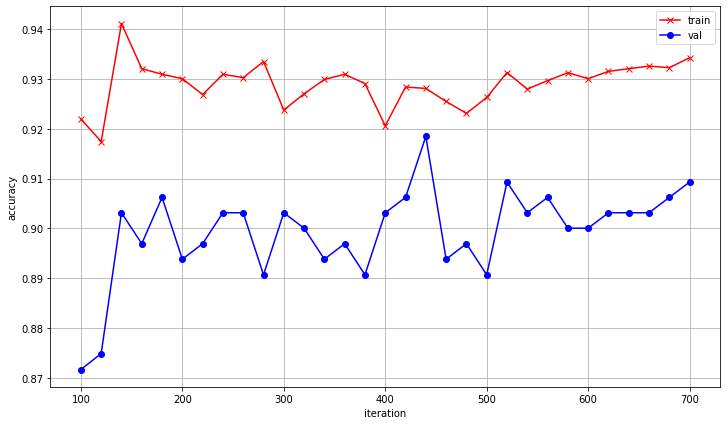

In [85]:
plot_learning_curve(search_xgb.best_estimator_)

In [86]:
pred_xgb = search_xgb.best_estimator_.predict(test_data.values)

In [87]:
save_results(test_data, pred_xgb, 'xgb_2')

1) look at overfitting
5) try xgboost
4) try SVC
6) try ensemble
7) clean notebook -> todos

- be careful when designing transformers - doe they work if a lot of data is missing?